The aim of this notebook is
1. to find the threshold for statistical filtering of Pseudo-Labels
2. to find whether a custom impl. of corner calculation for a bbox is the same the one used in pixor official

In [21]:
import os
from pathlib import Path
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader

home = os.path.join(os.path.expanduser("~"), "buni")

dataset_path = os.path.join(home, "dataset", "av2", "train")
dataset_path = Path(dataset_path)
dataloader = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

scene_idx = 1
print(f"All logs: {dataloader.get_log_ids()} \nand we select scene {dataloader.get_log_ids()[scene_idx]}")
scene_id = dataloader.get_log_ids()[scene_idx]

print(f"Scene {scene_id} has {len(dataloader.get_ordered_log_lidar_timestamps(scene_id))} frames")

All logs: ['ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd', 'ff6adc87-5f47-32f7-b36a-546453c0e332', 'ff8e7fdb-1073-3592-ba5e-8111bc3ce48b'] 
and we select scene ff6adc87-5f47-32f7-b36a-546453c0e332
Scene ff6adc87-5f47-32f7-b36a-546453c0e332 has 157 frames


In [22]:
# frame_id = 315968449159644000
frame_idx = 45
frame_id = dataloader.get_ordered_log_lidar_timestamps(scene_id)[frame_idx]

print(f"Scene selected: {scene_id},\nFrame selected: {frame_id}")

Scene selected: ff6adc87-5f47-32f7-b36a-546453c0e332,
Frame selected: 315968453659813000


In [23]:
from av2.structures.sweep import Sweep

frame_path = dataloader.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)
sweep = Sweep.from_feather(frame_path)

points = sweep.xyz

In [24]:
import numpy as np


ge_path = os.path.join(home, "output-data","av2", "ground-estimation")

print(os.listdir(ge_path))

frames = np.array(os.listdir(os.path.join(ge_path, scene_id)))

frames[0]

['ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd', 'ff6adc87-5f47-32f7-b36a-546453c0e332', 'ff8e7fdb-1073-3592-ba5e-8111bc3ce48b']


'315968449159644000'

In [25]:
ge_frame_path = os.path.join(ge_path, scene_id, str(frame_id))
os.listdir(ge_frame_path)

['ground.feather', 'non_ground.feather']

+ Ground and non_ground points, even in dataframe, are stored in float64


In [26]:
import pandas as pd


ground_df = pd.read_feather(ge_frame_path + "\\ground.feather")
non_ground_df = pd.read_feather(ge_frame_path + "\\non_ground.feather")

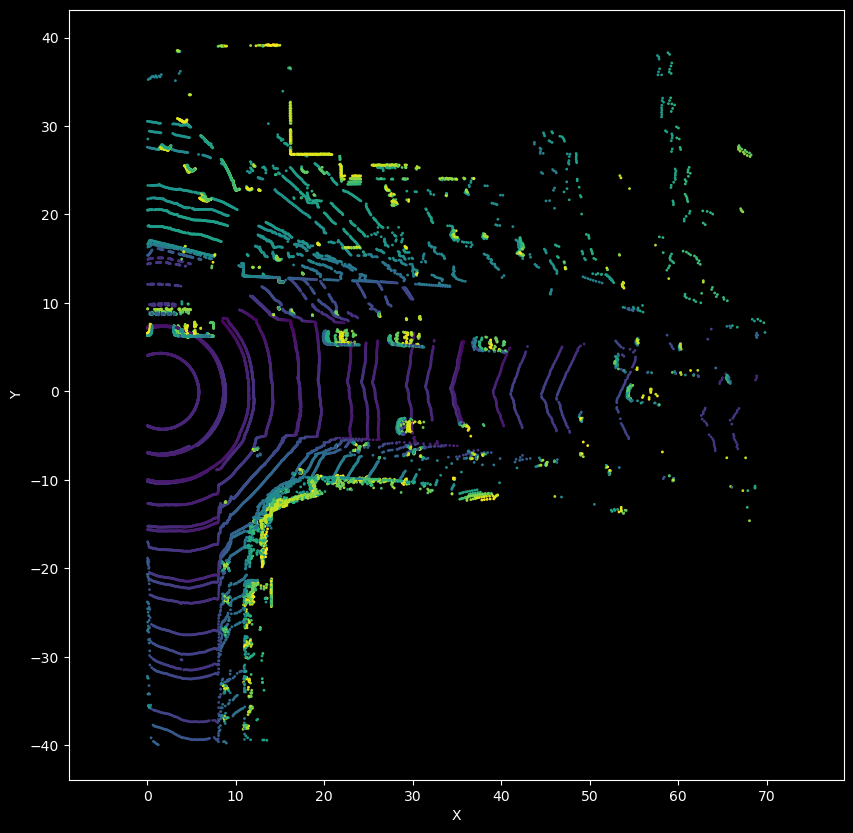

In [27]:
from prototype_utils import *

plot_bev_dark(filter_roi(points))

In [28]:
non_ground = non_ground_df.to_numpy()

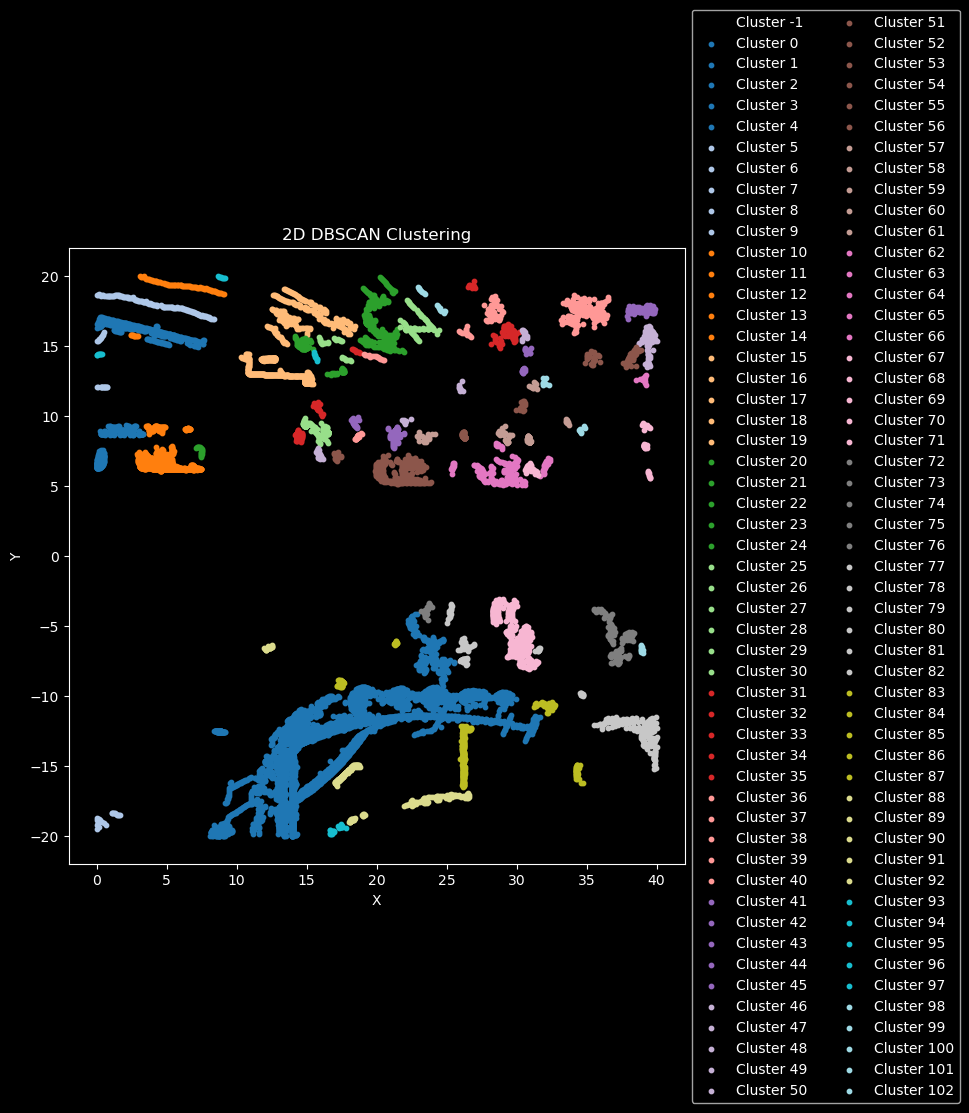

In [29]:
from bboxer_av2 import bboxer
from bboxer_av2 import utils as box_utils

bbox_estimator = bboxer.Bboxer()
bbox_estimator.cluster(points=non_ground[:,:2],visualize=True)
plt.show()

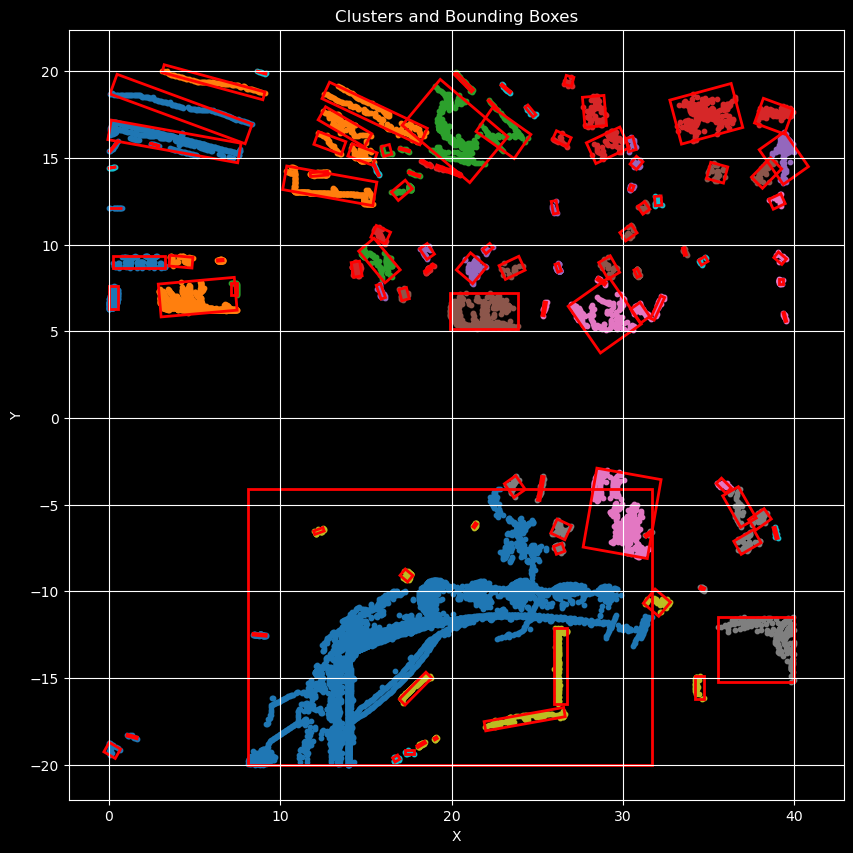

In [30]:
rects_modest = bbox_estimator.estimate_bboxes_from_clusters_modest(
    bbox_estimator.clustered_points,
    bbox_estimator.clustered_labels,
    fit_method="closeness_to_edge"
)

box_utils.visualize_bboxes_for_modest_fitting(
    bbox_estimator.clustered_points,
    bbox_estimator.clustered_labels,
    rects_modest,
)

In [31]:
rects_modest[0]['box_center'].shape

(2,)

In [32]:
# Transform data into a DataFrame
rects_df = pd.DataFrame({
    'cx': [item['box_center'][0] for item in rects_modest],
    'cy': [item['box_center'][1] for item in rects_modest],
    'l': [item['box_length'] for item in rects_modest],
    'w': [item['box_width'] for item in rects_modest],
    'ry': [item['ry'] for item in rects_modest]
})

In [33]:
rects_np = rects_df.to_numpy()

In [34]:
cx, cy = rects_np[0, 0], rects_np[0, 1]

np.array([cx, cy]).shape

(2,)

In [ ]:
from typing import Tuple

def get_bbox_corners_custom(params: Tuple) -> list:
    """
    Calculate the four corners of each bounding box from parameters.

    Args:
        bbox_params: List of tuples, each containing (cx, cy, length, width, angle)
                    where cx,cy is center, length/width are dimensions, angle in radians

    Returns:
        corners: A (4,2) numpy array containing the four corners of the bounding box
    """

    cx, cy, length, width, ry = params
    
    # Half-dimensions
    half_length = length / 2
    half_width = width / 2
    
    # Rotation matrix
    rotation_matrix = np.array([
        [np.cos(ry), -np.sin(ry)],
        [np.sin(ry),  np.cos(ry)]
    ])
    
    # Local frame corners in clockwise order
    local_corners = np.array([
        [-half_length,  -half_width],
        [-half_length, half_width],
        [ half_length, half_width],
        [ half_length,  -half_width]
    ])
    
    # Transform to global frame
    global_corners = (rotation_matrix @ local_corners.T).T + np.array([cx, cy])
    return global_corners

In [36]:
from shapely.geometry import Polygon

corners4x2 = [box_utils.get_bbox_corners(np.array([cx, cy]), l, w, ry) for cx, cy, l, w, ry in rects_np]

corners4x2_custom = [get_bbox_corners_custom((cx,cy,l,w,ry)) for (cx, cy, l, w, ry) in rects_np]
polygons = [Polygon(corner) for corner in corners4x2]

areas = [polygon.area for polygon in polygons]


In [37]:
cx, cy, len, width, anmgle = rects_np[0]

get_bbox_corners_custom((cx, cy, len, width, anmgle)).shape

(4, 2)

In [17]:
percentile_75 = np.percentile(areas, 75)
percentile_50 = np.percentile(areas, 50)
percentile_60 = np.percentile(areas, 60)
area_hard_threshold = 80
filtered_polygons75 = [{"polygon": polygon, "area": area} for polygon, area in zip(polygons, areas) if area > percentile_75 and area < area_hard_threshold]
filtered_polygons60 = [{"polygon": polygon, "area": area} for polygon, area in zip(polygons, areas) if area > percentile_60 and area < area_hard_threshold]
filtered_polygons50 = [{"polygon": polygon, "area": area} for polygon, area in zip(polygons, areas) if area > percentile_50 and area < area_hard_threshold]

In [18]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as mplPolygon

def visualize_polygons_for_modest_fitting(clustered_points, clustered_labels, filtered_polygons):
    """
    Visualize clusters and their corresponding filtered polygons.
    
    Args:
        clustered_points (np.ndarray): N x 2 array of (x, y) points.
        clustered_labels (np.ndarray): N-length array of cluster labels for the points.
        filtered_polygons (List[Dict]): List of dictionaries containing polygons and their areas.
    """
    # Create a color map for clusters
    unique_labels = set(clustered_labels)
    colors = plt.cm.get_cmap("tab10", len(unique_labels))

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot each cluster
    for label in unique_labels:
        if label == -1:
            # Optionally skip noise points if using DBSCAN
            continue

        # Select points for this cluster
        cluster_points = clustered_points[clustered_labels == label]

        # Plot the points of the cluster (using same color but without labels)
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, color=colors(label))

    # Plot filtered polygons
    for polygon_entry in filtered_polygons:
        polygon = polygon_entry["polygon"]
        if not isinstance(polygon, Polygon):
            continue  # Ensure we only work with Shapely Polygons
        coords = np.array(polygon.exterior.coords)

        # Create a polygon patch and add it to the plot
        patch = mplPolygon(coords, fill=None, edgecolor='r', linewidth=2)
        ax.add_patch(patch)

    # Add labels and remove legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Clusters and Filtered Polygons')
    ax.grid(True)
    plt.show()


CONCLUSION 1

Corners4x2_custom was made using a custom function to estimate corners. The function for corners4x2 is an implmentation which has been copied from pixor official database

From this we conclude that the corner calculation using `get_bbox_corners_custom` is the same as the one used in pixor 

Normal Corners


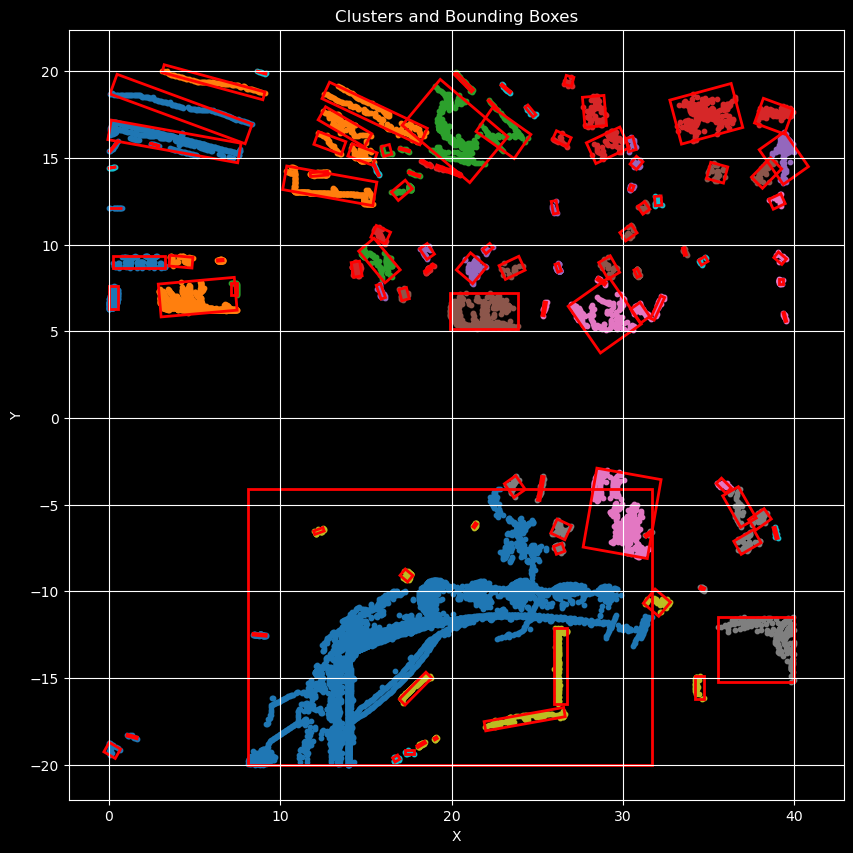

Custom Corners


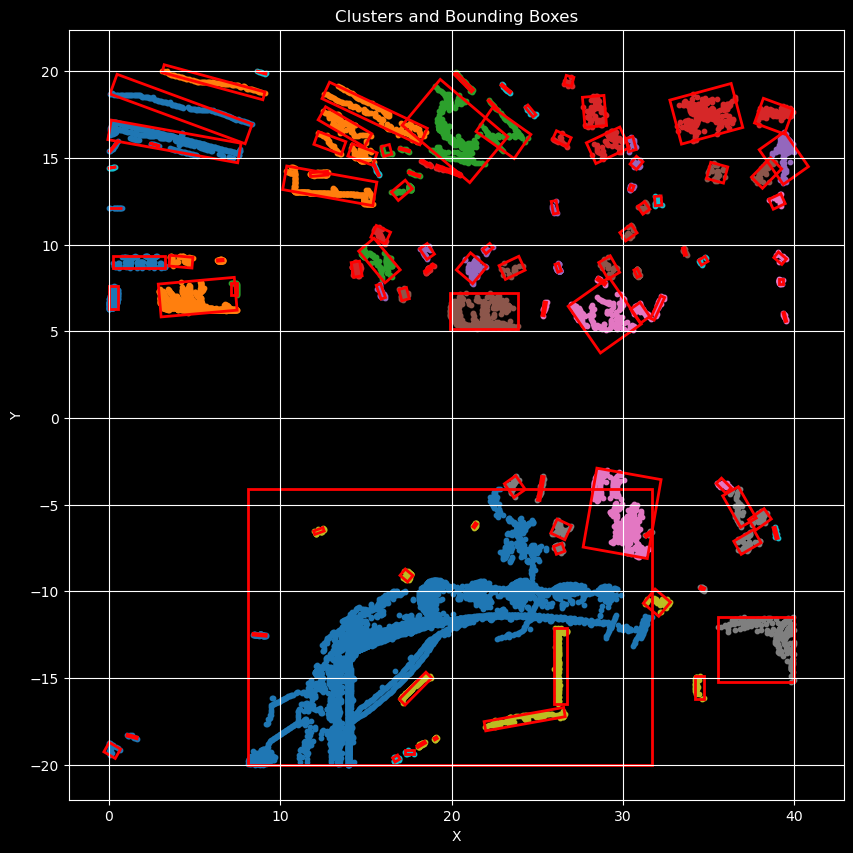

In [19]:
print("Normal Corners")
box_utils.visualize_bboxes_for_modest_fitting2(bbox_estimator.clustered_points, bbox_estimator.clustered_labels, corners4x2)
print("Custom Corners")
box_utils.visualize_bboxes_for_modest_fitting2(bbox_estimator.clustered_points, bbox_estimator.clustered_labels, corners4x2_custom)

CONCLUSION 2

BBoxes are statistically filtered on the basis of their areas. We filter out all bboxes that lie beloew 75th percentile

Rects modest


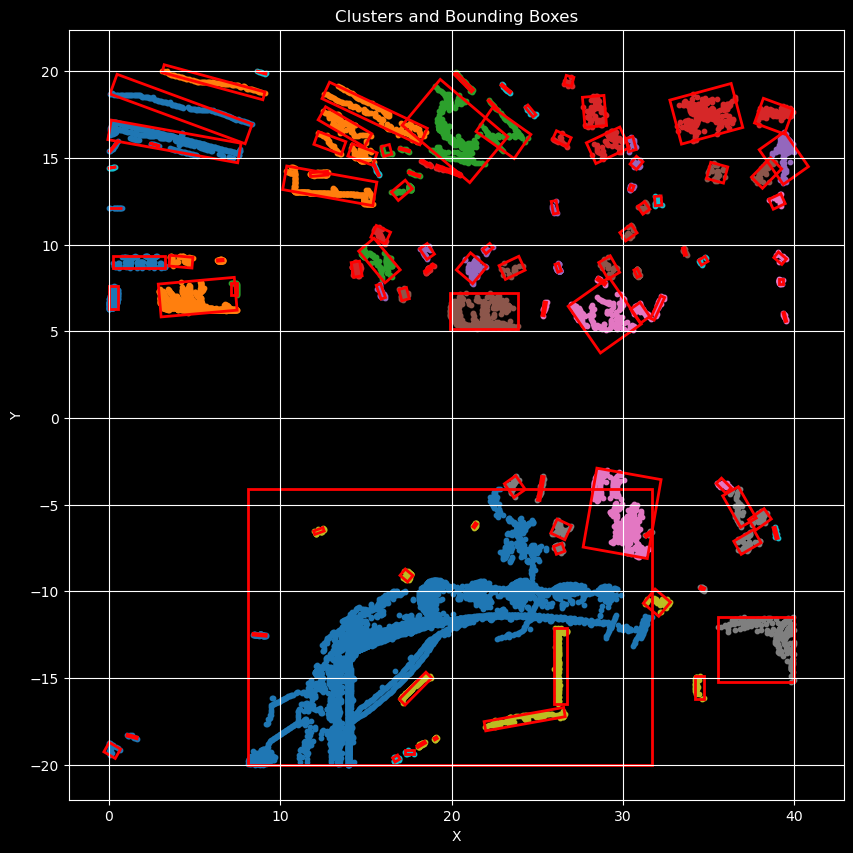

filtered polygons 50


C:\Users\Ravi\AppData\Local\Temp\ipykernel_21568\3929496238.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


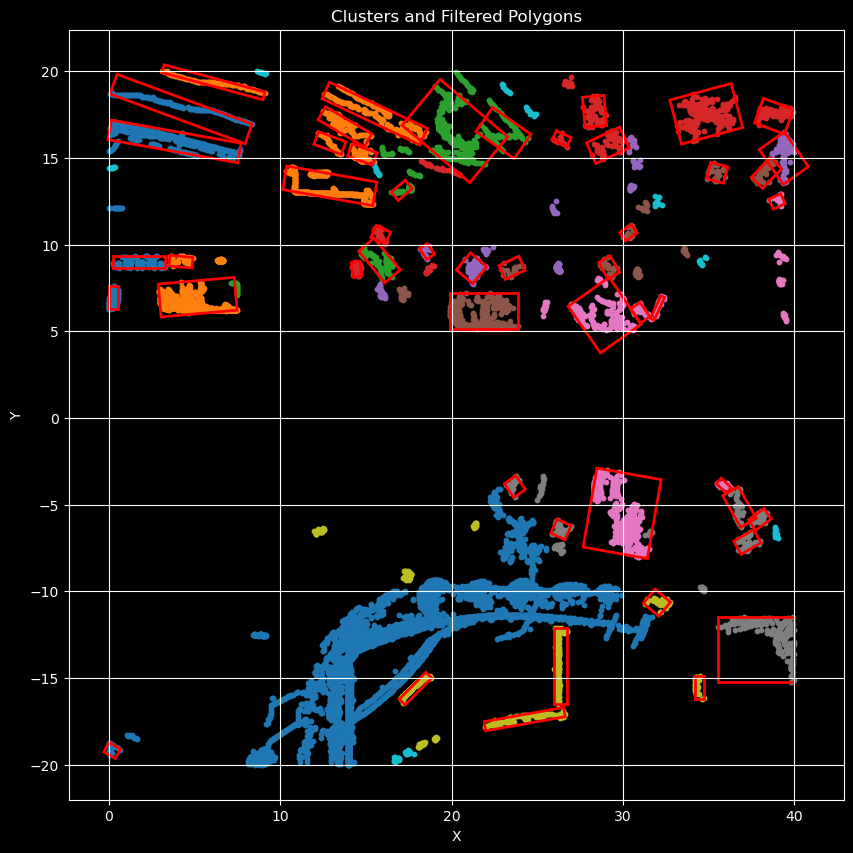

filtered polygons 60


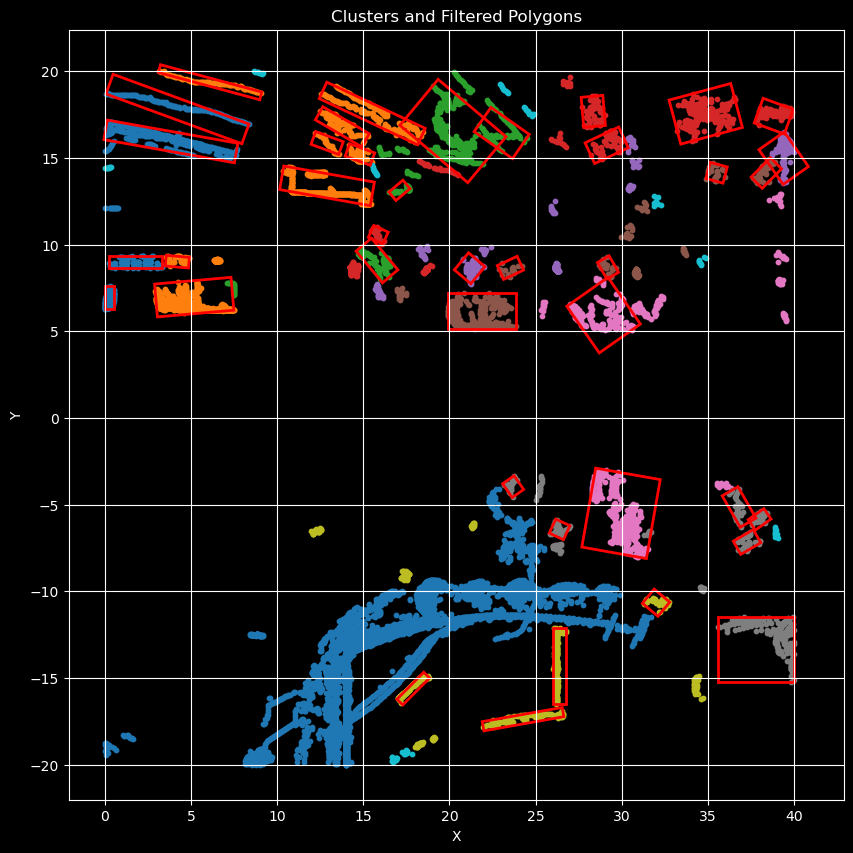

filtered polygons 75


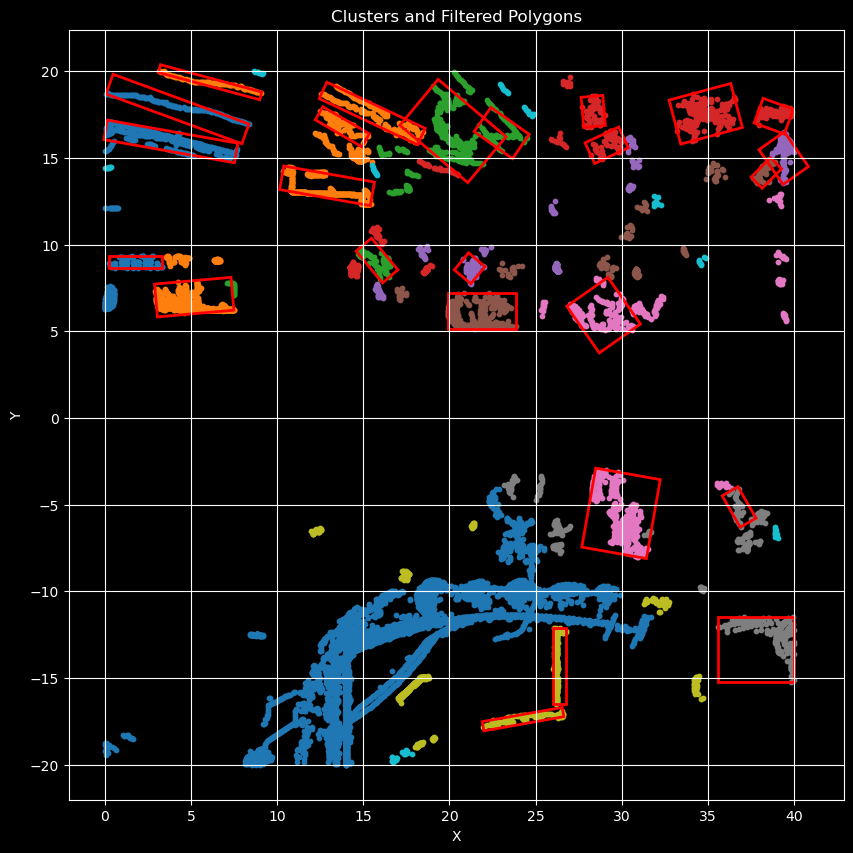

In [20]:
print("Rects modest")
box_utils.visualize_bboxes_for_modest_fitting(bbox_estimator.clustered_points, bbox_estimator.clustered_labels, rects_modest)
print("filtered polygons 50")
visualize_polygons_for_modest_fitting(bbox_estimator.clustered_points, bbox_estimator.clustered_labels, filtered_polygons50)
print("filtered polygons 60")
visualize_polygons_for_modest_fitting(bbox_estimator.clustered_points, bbox_estimator.clustered_labels, filtered_polygons60)
print("filtered polygons 75")
visualize_polygons_for_modest_fitting(bbox_estimator.clustered_points, bbox_estimator.clustered_labels, filtered_polygons75)
